In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done, goal):
        self.buffer.append((state, action, reward, next_state, done, goal))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done, goal = zip(*random.sample(self.buffer, batch_size))
        return np.stack(state), action, reward, np.stack(next_state), done, np.stack(goal)
    
    def __len__(self):
        return len(self.buffer)
class ReplayBuffer_imitation(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done, goal):
        self.buffer.append((state, action, reward, next_state, done, goal))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done, goal = zip(*random.sample(self.buffer, batch_size))
        return np.stack(state), action, reward, np.stack(next_state), done, np.stack(goal)
    
    def __len__(self):
        return len(self.buffer)
    

In [3]:
class Env(object):
    def __init__(self, num_bits):
        self.num_bits = num_bits
    
    def reset(self):
        self.done      = False
        self.num_steps = 0
        self.state     = np.random.randint(2, size=self.num_bits)
        self.target    = np.random.randint(2, size=self.num_bits)
        return self.state, self.target
    
    def step(self, action):
        if self.done:
            raise RESET
        
        self.state[action] = 1 - self.state[action]
        
        if self.num_steps > self.num_bits + 1:
            self.done = True
        self.num_steps += 1
        
        if np.sum(self.state == self.target) == self.num_bits:
            self.done = True
            return np.copy(self.state), 0, self.done, {}
        else:
            return np.copy(self.state), -1, self.done, {}

In [4]:
class Model(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size=256):
        super(Model, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs,  hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_outputs)
    
    def forward(self, state, goal):
        x = torch.cat([state, goal], 1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
    
class Model_imitation(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size=256):
        super(Model_imitation, self).__init__()
        self.linear1 = nn.Linear(num_inputs,  hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_outputs)
    def forward(self, state, goal):
        x = torch.cat([state, goal], 1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [5]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Mean Reward: %s. frame: %s' % (rewards[-1], frame_idx))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [6]:
def compute_td_error(batch_size):
    if batch_size > len(replay_buffer):
        return None

    state, action, reward, next_state, done, goal = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    action     = torch.LongTensor(action).unsqueeze(1).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    goal       = torch.FloatTensor(goal).to(device)
    mask       = torch.FloatTensor(1 - np.float32(done)).unsqueeze(1).to(device)
    
    q_values = model(state, goal)
    q_value  = q_values.gather(1, action)

    next_q_values = target_model(next_state, goal)
    target_action = next_q_values.max(1)[1].unsqueeze(1)
    next_q_value  = target_model(next_state, goal).gather(1, target_action)

    expected_q_value = reward + 0.99 * next_q_value * mask

    loss = (q_value - expected_q_value.detach()).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

def compute_cross_ent_error(batch_size):
    if batch_size>len(replay_buffer_imitation):
        return None
    state, action, reward, next_state, done, goal = replay_buffer_imitation.sample(batch_size)
    state          = torch.FloatTensor(state).to(device)
    goal           = torch.FloatTensor(goal).to(device)
    action_target  = torch.LongTensor(action).to(device)
    action_pred    = model_imitation(state, goal)
    #print(action_target.shape)
    #print(action_pred.shape)
    loss_func = nn.CrossEntropyLoss()
    loss = loss_func(action_pred,action_target)
    #loss = (action_target - action_pred.detach()).pow(2).mean()
    optimizer_imitation.zero_grad()
    loss.backward()
    optimizer_imitation.step()
    return loss
    
    

## HER: 0* q_value_add

In [7]:
def get_action(model, state, goal, epsilon=0.1):
    if random.random() < 0.1:
        return random.randrange(env.num_bits)
    
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    goal  = torch.FloatTensor(goal).unsqueeze(0).to(device)
    q_value = model(state, goal)
    q_value_add = model_imitation(state, goal)
    return (1*q_value+0.0*q_value_add).max(1)[1].item()

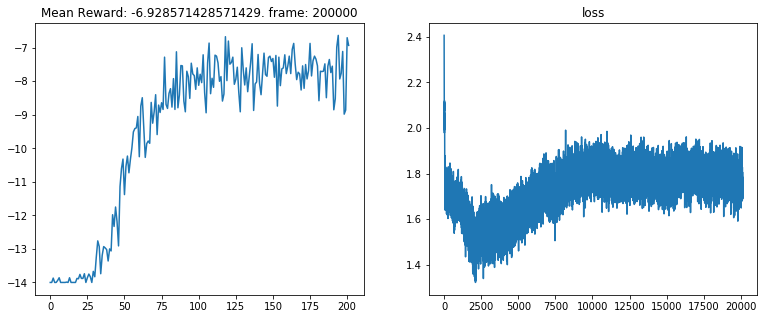

In [8]:
EXP_HER_past = []
for rep in range(10):
    

    num_bits = 11
    env = Env(num_bits)

    model        = Model(2 * num_bits, num_bits).to(device)
    target_model = Model(2 * num_bits, num_bits).to(device)
    update_target(model, target_model)

    model_imitation = Model_imitation(2 * num_bits, num_bits).to(device)

    #hyperparams:
    batch_size = 5
    new_goals  = 5
    max_frames = 200000

    optimizer = optim.Adam(model.parameters())
    optimizer_imitation = optim.Adam(model_imitation.parameters())
    replay_buffer = ReplayBuffer(10000)
    replay_buffer_imitation = ReplayBuffer_imitation(50000)

    frame_idx = 0
    all_rewards = []
    losses = []
    plotter = []

    while frame_idx < max_frames:
        state, goal = env.reset()
        done = False
        episode = []
        total_reward = 0
        while not done:
            action = get_action(model, state, goal)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, reward, done, next_state, goal))
            replay_buffer.push(state, action, reward, next_state, done, goal)
            state = next_state
            total_reward += reward
            frame_idx += 1

            if frame_idx % 10000 == 0:
                plot(frame_idx, [np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)], losses)
                #print(plotter)
                plotter=[np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)]
        all_rewards.append(total_reward)


        new_episode = []
        for i,(state, reward, done, next_state, goal) in enumerate(episode):
            for t in np.random.choice(num_bits, new_goals):
            #for t in [i]:
                try:
                    episode[t]
                except:
                    continue
                #if i<t:
                #    continue
                new_goal = episode[t][-2]
                if np.sum(next_state == new_goal) == num_bits:
                    reward = 0
                else:
                    reward = -1
                    
                '''加了一个action'''
                action = get_action(model, state, goal)
                replay_buffer.push(state, action, reward, next_state, done, new_goal) # HER
                replay_buffer_imitation.push(state, action, reward, next_state, done, new_goal) # IER
                #new_episode.append((state, reward, done, next_state, new_goal))


        loss1 = compute_cross_ent_error(500)
        loss = compute_td_error(batch_size)
        if loss1 is not None: losses.append(loss1.data.item())
            
    EXP_HER_past.append(plotter)

In [9]:
minlen = 200
for i in range(10):
    minlen = min([minlen,len(EXP_HER_past[i])])
print(minlen)
arr = []
for i in range(10):
    arr.append(EXP_HER_past[i][:minlen])
arr = np.asarray(arr)
print(arr.shape)

197
(10, 197)


In [10]:
HER_arr = arr

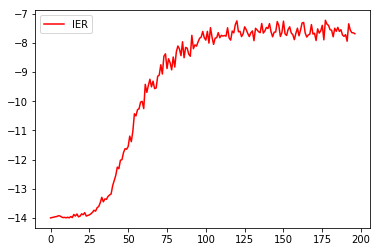

In [11]:
plt.plot(np.mean(HER_arr,0),'r')
#plt.plot(np.mean(HER_arr,0),'b')
#plt.plot(np.mean(No_arr,0),'g')
plt.legend(['IER','HER','None'])
plt.show()

### ADD: IER 1*q_value + 0.1 * q_value_add

In [12]:
def get_action(model, state, goal, epsilon=0.1):
    if random.random() < 0.1:
        return random.randrange(env.num_bits)
    
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    goal  = torch.FloatTensor(goal).unsqueeze(0).to(device)
    q_value = model(state, goal)
    q_value_add = model_imitation(state, goal)
    return (1*q_value+0.1*q_value_add).max(1)[1].item()

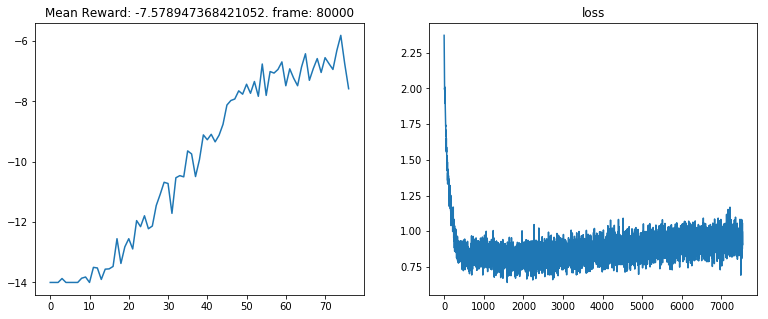

In [ ]:
EXP_IER_past = []
for rep in range(10):
    

    num_bits = 11
    env = Env(num_bits)

    model        = Model(2 * num_bits, num_bits).to(device)
    target_model = Model(2 * num_bits, num_bits).to(device)
    update_target(model, target_model)

    model_imitation = Model_imitation(2 * num_bits, num_bits).to(device)

    #hyperparams:
    batch_size = 5
    new_goals  = 5
    max_frames = 200000

    optimizer = optim.Adam(model.parameters())
    optimizer_imitation = optim.Adam(model_imitation.parameters())
    replay_buffer = ReplayBuffer(10000)
    replay_buffer_imitation = ReplayBuffer_imitation(50000)

    frame_idx = 0
    all_rewards = []
    losses = []
    plotter = []

    while frame_idx < max_frames:
        state, goal = env.reset()
        done = False
        episode = []
        total_reward = 0
        while not done:
            action = get_action(model, state, goal)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, reward, done, next_state, goal))
            replay_buffer.push(state, action, reward, next_state, done, goal)
            state = next_state
            total_reward += reward
            frame_idx += 1

            if frame_idx % 10000 == 0:
                plot(frame_idx, [np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)], losses)
                #print(plotter)
                plotter=[np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)]
        all_rewards.append(total_reward)


        new_episode = []
        for i,(state, reward, done, next_state, goal) in enumerate(episode):
            for t in np.random.choice(num_bits, new_goals):
            #for t in [i]:
                try:
                    episode[t]
                except:
                    continue
                #if i<t:
                #    continue
                new_goal = episode[t][-2]
                if np.sum(next_state == new_goal) == num_bits:
                    reward = 0
                else:
                    reward = -1
                    
                '''加了一个action'''
                action = get_action(model, state, goal)
                replay_buffer.push(state, action, reward, next_state, done, new_goal) # HER
                if t == i:
                    replay_buffer_imitation.push(state, action, reward, next_state, done, new_goal) # IER
                #new_episode.append((state, reward, done, next_state, new_goal))


        loss1 = compute_cross_ent_error(500)
        loss = compute_td_error(batch_size)
        if loss1 is not None: losses.append(loss1.data.item())
            
    EXP_IER_past.append(plotter)

In [ ]:
minlen = 200
for i in range(10):
    minlen = min([minlen,len(EXP_IER_past[i])])
print(minlen)
arr = []
for i in range(10):
    arr.append(EXP_IER_past[i][:minlen])
arr = np.asarray(arr)
print(arr.shape)

In [ ]:
IER_arr = arr

In [ ]:
plt.plot(np.mean(HER_arr,0),'r')
plt.plot(np.mean(IER_arr,0),'b')
#plt.plot(np.mean(No_arr,0),'g')
plt.legend(['HER','IER','None'])
plt.show()

### only Imitation

In [ ]:
def get_action(model, state, goal, epsilon=0.1):
    if random.random() < 0.1:
        return random.randrange(env.num_bits)
    
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    goal  = torch.FloatTensor(goal).unsqueeze(0).to(device)
    q_value = model(state, goal)
    q_value_add = model_imitation(state, goal)
    return (0.*q_value+1*q_value_add).max(1)[1].item()

In [ ]:
EXP_Imit = []
for rep in range(1):
    

    num_bits = 11
    env = Env(num_bits)

    model        = Model(2 * num_bits, num_bits).to(device)
    target_model = Model(2 * num_bits, num_bits).to(device)
    update_target(model, target_model)

    model_imitation = Model_imitation(2 * num_bits, num_bits).to(device)

    #hyperparams:
    batch_size = 5
    new_goals  = 5
    max_frames = 200000

    optimizer = optim.Adam(model.parameters())
    optimizer_imitation = optim.Adam(model_imitation.parameters())
    replay_buffer = ReplayBuffer(10000)
    replay_buffer_imitation = ReplayBuffer_imitation(50000)

    frame_idx = 0
    all_rewards = []
    losses = []
    plotter = []

    while frame_idx < max_frames:
        state, goal = env.reset()
        done = False
        episode = []
        total_reward = 0
        while not done:
            action = get_action(model, state, goal)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, reward, done, next_state, goal))
            replay_buffer.push(state, action, reward, next_state, done, goal)
            state = next_state
            total_reward += reward
            frame_idx += 1

            if frame_idx % 10000 == 0:
                plot(frame_idx, [np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)], losses)
                #print(plotter)
                plotter=[np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)]
        all_rewards.append(total_reward)


        new_episode = []
        for i,(state, reward, done, next_state, goal) in enumerate(episode):
            for t in np.random.choice(num_bits, new_goals):
            #for t in [i]:
                try:
                    episode[t]
                except:
                    continue
                #if i<t:
                #    continue
                new_goal = episode[t][-2]
                if np.sum(next_state == new_goal) == num_bits:
                    reward = 0
                else:
                    reward = -1
                    
                '''加了一个action'''
                action = get_action(model, state, goal)
                replay_buffer.push(state, action, reward, next_state, done, new_goal) # HER
                if t == i:
                    replay_buffer_imitation.push(state, action, reward, next_state, done, new_goal) # IER
                #new_episode.append((state, reward, done, next_state, new_goal))


        loss1 = compute_cross_ent_error(500)
        loss = compute_td_error(batch_size)
        if loss1 is not None: losses.append(loss1.data.item())
            
    EXP_Imit.append(plotter)

In [ ]:
minlen = 200
for i in range(1):
    minlen = min([minlen,len(EXP_Imit[i])])
print(minlen)
arr = []
for i in range(1):
    arr.append(EXP_Imit[i][:minlen])
arr = np.asarray(arr)
print(arr.shape)

In [ ]:
Imit_arr = arr

In [ ]:
plt.plot(np.mean(HER_arr,0),'r')
plt.plot(np.mean(IER_arr,0),'b')
plt.plot(np.mean(Imit_arr,0),'g')
plt.legend(['HER','IER','Imitation'])
plt.show()

### +0.3 add

In [ ]:
def get_action(model, state, goal, epsilon=0.1):
    if random.random() < 0.1:
        return random.randrange(env.num_bits)
    
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    goal  = torch.FloatTensor(goal).unsqueeze(0).to(device)
    q_value = model(state, goal)
    q_value_add = model_imitation(state, goal)
    return (1*q_value+0.03*q_value_add).max(1)[1].item()

In [ ]:
EXP_IER03_past = []
for rep in range(10):
    

    num_bits = 11
    env = Env(num_bits)

    model        = Model(2 * num_bits, num_bits).to(device)
    target_model = Model(2 * num_bits, num_bits).to(device)
    update_target(model, target_model)

    model_imitation = Model_imitation(2 * num_bits, num_bits).to(device)

    #hyperparams:
    batch_size = 5
    new_goals  = 5
    max_frames = 200000

    optimizer = optim.Adam(model.parameters())
    optimizer_imitation = optim.Adam(model_imitation.parameters())
    replay_buffer = ReplayBuffer(10000)
    replay_buffer_imitation = ReplayBuffer_imitation(50000)

    frame_idx = 0
    all_rewards = []
    losses = []
    plotter = []

    while frame_idx < max_frames:
        state, goal = env.reset()
        done = False
        episode = []
        total_reward = 0
        while not done:
            action = get_action(model, state, goal)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, reward, done, next_state, goal))
            replay_buffer.push(state, action, reward, next_state, done, goal)
            state = next_state
            total_reward += reward
            frame_idx += 1

            if frame_idx % 10000 == 0:
                plot(frame_idx, [np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)], losses)
                #print(plotter)
                plotter=[np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)]
        all_rewards.append(total_reward)


        new_episode = []
        for i,(state, reward, done, next_state, goal) in enumerate(episode):
            for t in np.random.choice(num_bits, new_goals):
            #for t in [i]:
                try:
                    episode[t]
                except:
                    continue
                #if i<t:
                #    continue
                new_goal = episode[t][-2]
                if np.sum(next_state == new_goal) == num_bits:
                    reward = 0
                else:
                    reward = -1
                    
                '''加了一个action'''
                action = get_action(model, state, goal)
                replay_buffer.push(state, action, reward, next_state, done, new_goal) # HER
                if t == i:
                    replay_buffer_imitation.push(state, action, reward, next_state, done, new_goal) # IER
                #new_episode.append((state, reward, done, next_state, new_goal))


        loss1 = compute_cross_ent_error(500)
        loss = compute_td_error(batch_size)
        if loss1 is not None: losses.append(loss1.data.item())
            
    EXP_IER03_past.append(plotter)

In [ ]:
minlen = 200
for i in range(10):
    minlen = min([minlen,len(EXP_IER03_past[i])])
print(minlen)
arr = []
for i in range(10):
    arr.append(EXP_IER03_past[i][:minlen])
arr = np.asarray(arr)
print(arr.shape)
IER03_arr = arr

In [ ]:
plt.plot(np.mean(HER_arr,0),'r')
plt.plot(np.mean(IER_arr,0),'b')
plt.plot(np.mean(Imit_arr,0),'g')
plt.plot(np.mean(IER03_arr,0))
plt.legend(['HER','IER','Imitation','IER 0.3'])
plt.show()

### IER 0.5

In [ ]:
def get_action(model, state, goal, epsilon=0.1):
    if random.random() < 0.1:
        return random.randrange(env.num_bits)
    
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    goal  = torch.FloatTensor(goal).unsqueeze(0).to(device)
    q_value = model(state, goal)
    q_value_add = model_imitation(state, goal)
    return (1*q_value+0.05*q_value_add).max(1)[1].item()

In [ ]:
EXP_IER05_past = []
for rep in range(10):
    

    num_bits = 11
    env = Env(num_bits)

    model        = Model(2 * num_bits, num_bits).to(device)
    target_model = Model(2 * num_bits, num_bits).to(device)
    update_target(model, target_model)

    model_imitation = Model_imitation(2 * num_bits, num_bits).to(device)

    #hyperparams:
    batch_size = 5
    new_goals  = 5
    max_frames = 200000

    optimizer = optim.Adam(model.parameters())
    optimizer_imitation = optim.Adam(model_imitation.parameters())
    replay_buffer = ReplayBuffer(10000)
    replay_buffer_imitation = ReplayBuffer_imitation(50000)

    frame_idx = 0
    all_rewards = []
    losses = []
    plotter = []

    while frame_idx < max_frames:
        state, goal = env.reset()
        done = False
        episode = []
        total_reward = 0
        while not done:
            action = get_action(model, state, goal)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, reward, done, next_state, goal))
            replay_buffer.push(state, action, reward, next_state, done, goal)
            state = next_state
            total_reward += reward
            frame_idx += 1

            if frame_idx % 10000 == 0:
                plot(frame_idx, [np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)], losses)
                #print(plotter)
                plotter=[np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)]
        all_rewards.append(total_reward)


        new_episode = []
        for i,(state, reward, done, next_state, goal) in enumerate(episode):
            for t in np.random.choice(num_bits, new_goals):
            #for t in [i]:
                try:
                    episode[t]
                except:
                    continue
                #if i<t:
                #    continue
                new_goal = episode[t][-2]
                if np.sum(next_state == new_goal) == num_bits:
                    reward = 0
                else:
                    reward = -1
                    
                '''加了一个action'''
                action = get_action(model, state, goal)
                replay_buffer.push(state, action, reward, next_state, done, new_goal) # HER
                if t == i:
                    replay_buffer_imitation.push(state, action, reward, next_state, done, new_goal) # IER
                #new_episode.append((state, reward, done, next_state, new_goal))


        loss1 = compute_cross_ent_error(500)
        loss = compute_td_error(batch_size)
        if loss1 is not None: losses.append(loss1.data.item())
            
    EXP_IER05_past.append(plotter)

In [ ]:
minlen = 200
for i in range(10):
    minlen = min([minlen,len(EXP_IER05_past[i])])
print(minlen)
arr = []
for i in range(10):
    arr.append(EXP_IER05_past[i][:minlen])
arr = np.asarray(arr)
print(arr.shape)
IER05_arr = arr

In [ ]:
plt.plot(np.mean(HER_arr,0),'r')
plt.plot(np.mean(IER_arr,0),'b')
plt.plot(np.mean(Imit_arr,0),'g')
plt.plot(np.mean(IER03_arr,0))
plt.plot(np.mean(IER05_arr,0))
plt.legend(['HER','IER','Imitation','IER 0.03','IER 0.05'])
plt.show()

### IER 1.0

In [ ]:
def get_action(model, state, goal, epsilon=0.1):
    if random.random() < 0.1:
        return random.randrange(env.num_bits)
    
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    goal  = torch.FloatTensor(goal).unsqueeze(0).to(device)
    q_value = model(state, goal)
    q_value_add = model_imitation(state, goal)
    return (1*q_value+0.01*q_value_add).max(1)[1].item()

In [ ]:
EXP_IER10_past = []
for rep in range(10):
    

    num_bits = 11
    env = Env(num_bits)

    model        = Model(2 * num_bits, num_bits).to(device)
    target_model = Model(2 * num_bits, num_bits).to(device)
    update_target(model, target_model)

    model_imitation = Model_imitation(2 * num_bits, num_bits).to(device)

    #hyperparams:
    batch_size = 5
    new_goals  = 5
    max_frames = 200000

    optimizer = optim.Adam(model.parameters())
    optimizer_imitation = optim.Adam(model_imitation.parameters())
    replay_buffer = ReplayBuffer(10000)
    replay_buffer_imitation = ReplayBuffer_imitation(50000)

    frame_idx = 0
    all_rewards = []
    losses = []
    plotter = []

    while frame_idx < max_frames:
        state, goal = env.reset()
        done = False
        episode = []
        total_reward = 0
        while not done:
            action = get_action(model, state, goal)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, reward, done, next_state, goal))
            replay_buffer.push(state, action, reward, next_state, done, goal)
            state = next_state
            total_reward += reward
            frame_idx += 1

            if frame_idx % 10000 == 0:
                plot(frame_idx, [np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)], losses)
                #print(plotter)
                plotter=[np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)]
        all_rewards.append(total_reward)


        new_episode = []
        for i,(state, reward, done, next_state, goal) in enumerate(episode):
            for t in np.random.choice(num_bits, new_goals):
            #for t in [i]:
                try:
                    episode[t]
                except:
                    continue
                #if i<t:
                #    continue
                new_goal = episode[t][-2]
                if np.sum(next_state == new_goal) == num_bits:
                    reward = 0
                else:
                    reward = -1
                    
                '''加了一个action'''
                action = get_action(model, state, goal)
                replay_buffer.push(state, action, reward, next_state, done, new_goal) # HER
                if t == i:
                    replay_buffer_imitation.push(state, action, reward, next_state, done, new_goal) # IER
                #new_episode.append((state, reward, done, next_state, new_goal))


        loss1 = compute_cross_ent_error(500)
        loss = compute_td_error(batch_size)
        if loss1 is not None: losses.append(loss1.data.item())
            
    EXP_IER10_past.append(plotter)

In [ ]:
minlen = 200
for i in range(10):
    minlen = min([minlen,len(EXP_IER10_past[i])])
print(minlen)
arr = []
for i in range(10):
    arr.append(EXP_IER10_past[i][:minlen])
arr = np.asarray(arr)
print(arr.shape)
IER10_arr = arr

In [ ]:
plt.plot(np.mean(HER_arr,0),'r')
plt.plot(np.mean(IER_arr,0),'b')
plt.plot(np.mean(Imit_arr,0),'g')
plt.plot(np.mean(IER03_arr,0))
plt.plot(np.mean(IER05_arr,0))
plt.plot(np.mean(IER10_arr,0))
plt.legend(['HER','IER','Imitation','IER 0.03','IER 0.05','IER 0.01'])
plt.show()

In [ ]:
plt.plot(np.mean(HER_arr,0),'r')
plt.plot(np.mean(IER_arr,0),'b')
plt.plot(np.mean(Imit_arr,0),'g')
plt.plot(np.mean(IER03_arr,0))
plt.plot(np.mean(IER05_arr,0))
plt.plot(np.mean(IER10_arr,0))
plt.legend(['HER','IER 0.10','Imitation','IER 0.03','IER 0.05','IER 0.01'])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from seaborn import lineplot
import seaborn as sns
from pandas import DataFrame
def convert2seaborn(Lst):
    HID5_HER_df = DataFrame(Lst)
    test_num = []
    test_acc = []
    for i in range(np.shape(Lst)[1]):
        for j in range(np.shape(Lst)[0]):
            test_num.append(i)
            test_acc.append(HID5_HER_df[i][j])
    aa = DataFrame(np.stack((test_num,test_acc),1))
    aa.columns = ['Frames(1e4)','Reward']
    return aa
def convert2seaborn_succ(Lst):
    HID5_HER_df = DataFrame(Lst)
    test_num = []
    test_acc = []
    for i in range(np.shape(Lst)[1]):
        for j in range(np.shape(Lst)[0]):
            test_num.append(i)
            test_acc.append(HID5_HER_df[i][j])
    aa = DataFrame(np.stack((test_num,test_acc),1))
    aa.columns = ['Episode','Success Rate']
    return aa
import matplotlib.pyplot as plt
def smooth(y, radius, mode='two_sided', valid_only=False):
    '''
    Smooth signal y, where radius is determines the size of the window
    mode='twosided':
        average over the window [max(index - radius, 0), min(index + radius, len(y)-1)]
    mode='causal':
        average over the window [max(index - radius, 0), index]
    valid_only: put nan in entries where the full-sized window is not available
    '''
    assert mode in ('two_sided', 'causal')
    if len(y) < 2*radius+1:
        return np.ones_like(y) * y.mean()
    elif mode == 'two_sided':
        convkernel = np.ones(2 * radius+1)
        out = np.convolve(y, convkernel,mode='same') / np.convolve(np.ones_like(y), convkernel, mode='same')
        if valid_only:
            out[:radius] = out[-radius:] = np.nan
    elif mode == 'causal':
        convkernel = np.ones(radius)
        out = np.convolve(y, convkernel,mode='full') / np.convolve(np.ones_like(y), convkernel, mode='full')
        out = out[:-radius+1]
        if valid_only:
            out[:radius] = np.nan
    return out

In [ ]:
np.shape(HER_arr)

In [ ]:
plt.plot(np.mean(HER_arr,0),'r')
plt.plot(np.mean(IER_arr,0),'b')
plt.plot(np.mean(Imit_arr,0),'g')
plt.plot(np.mean(IER03_arr,0))
plt.plot(np.mean(IER05_arr,0))
plt.plot(np.mean(IER10_arr,0))

HER_arr_1 = convert2seaborn(HER_arr[:,:100])
IER_arr_1 = convert2seaborn(IER_arr[:,:100])
Imit_arr_1 = convert2seaborn(Imit_arr[:,:100])
IER03_arr_1 = convert2seaborn(IER03_arr[:,:100])
IER05_arr_1 = convert2seaborn(IER05_arr[:,:100])
IER10_arr_1 = convert2seaborn(IER10_arr[:,:100])


/home/hsun/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


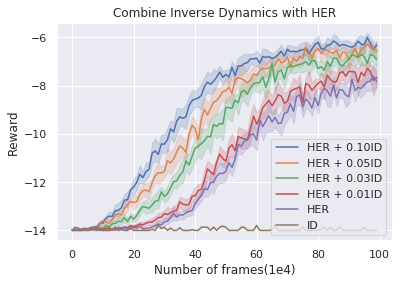

In [40]:
sns.set(style="darkgrid")

sns.lineplot(x='Frames(1e4)', y='Reward',
             data=IER_arr_1,label = 'HER + 0.10ID')

sns.lineplot(x='Frames(1e4)', y='Reward',
             data=IER05_arr_1,label = 'HER + 0.05ID')
sns.lineplot(x='Frames(1e4)', y='Reward',
             data=IER03_arr_1,label = 'HER + 0.03ID')
sns.lineplot(x='Frames(1e4)', y='Reward',
             data=IER10_arr_1,label = 'HER + 0.01ID')
sns.lineplot(x='Frames(1e4)', y='Reward',
             data=HER_arr_1,label = 'HER')
sns.lineplot(x='Frames(1e4)', y='Reward',
             data=Imit_arr_1,label = 'ID')
plt.xlabel('Number of frames(1e4)')
plt.legend(loc='lower right')
plt.title('Combine Inverse Dynamics with HER')
plt.savefig('Bitflip100_new.pdf',dpi=200,format='pdf')

In [ ]:
1

### As Reward Term?

In [73]:
def get_action(model, state, goal, epsilon=0.1):
    if random.random() < 0.1:
        return random.randrange(env.num_bits)
    
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    goal  = torch.FloatTensor(goal).unsqueeze(0).to(device)
    q_value = model(state, goal)
    q_value_add = model_imitation(state, goal)
    return (1.*q_value+0.*q_value_add).max(1)[1].item()
def get_action_imitation(model, state, goal, epsilon=0.1):
    if random.random() < 0.1:
        return random.randrange(env.num_bits)
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    goal  = torch.FloatTensor(goal).unsqueeze(0).to(device)
    q_value = model(state, goal)
    q_value_add = model_imitation(state, goal)
    return (1.*q_value_add).max(1)[1].item()

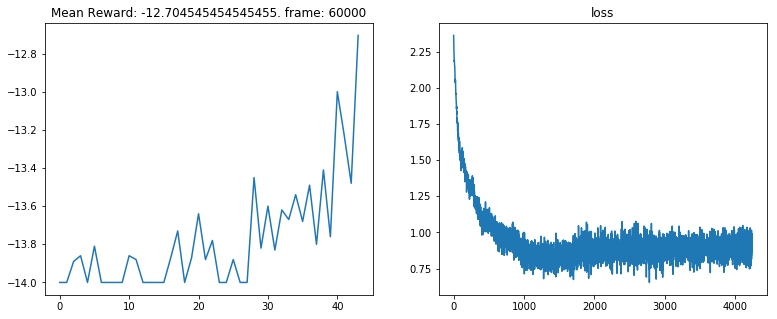

KeyboardInterrupt: 

In [78]:
EXP_reward = []
for rep in range(10):
    

    num_bits = 11
    env = Env(num_bits)

    model        = Model(2 * num_bits, num_bits).to(device)
    target_model = Model(2 * num_bits, num_bits).to(device)
    update_target(model, target_model)

    model_imitation = Model_imitation(2 * num_bits, num_bits).to(device)

    #hyperparams:
    batch_size = 5
    new_goals  = 5
    max_frames = 200000

    optimizer = optim.Adam(model.parameters())
    optimizer_imitation = optim.Adam(model_imitation.parameters())
    replay_buffer = ReplayBuffer(10000)
    replay_buffer_imitation = ReplayBuffer_imitation(50000)

    frame_idx = 0
    all_rewards = []
    losses = []
    plotter = []

    while frame_idx < max_frames:
        state, goal = env.reset()
        done = False
        episode = []
        total_reward = 0
        while not done:
            action = get_action(model, state, goal)
            next_state, reward, done, _ = env.step(action)
            
            action_imit = get_action_imitation(model,state,goal)
            
            if action_imit == action:
                flag = 1
                reward+=0.6
                '''超参'''
            else:
                flag = 0
            
            episode.append((state, reward, done, next_state, goal))
            replay_buffer.push(state, action, reward, next_state, done, goal)
            state = next_state
            total_reward += reward - flag * 0.6
            frame_idx += 1

            if frame_idx % 10000 == 0:
                plot(frame_idx, [np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)], losses)
                #print(plotter)
                plotter=[np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)]
        all_rewards.append(total_reward)


        new_episode = []
        for i,(state, reward, done, next_state, goal) in enumerate(episode):
            for t in np.random.choice(num_bits, new_goals):
            #for t in [i]:
                try:
                    episode[t]
                except:
                    continue
                #if i<t:
                #    continue
                new_goal = episode[t][-2]
                if np.sum(next_state == new_goal) == num_bits:
                    reward = 0
                else:
                    reward = -1
                    
                '''加了一个action'''
                action = get_action(model, state, goal)
                replay_buffer.push(state, action, reward, next_state, done, new_goal) # HER
                if t == i:
                    replay_buffer_imitation.push(state, action, reward, next_state, done, new_goal) # IER
                #new_episode.append((state, reward, done, next_state, new_goal))


        loss1 = compute_cross_ent_error(500)
        loss = compute_td_error(batch_size)
        if loss1 is not None: losses.append(loss1.data.item())
            
    EXP_reward.append(plotter)

In [ ]:
minlen = 200
for i in range(10):
    minlen = min([minlen,len(EXP_Imit[i])])
print(minlen)
arr = []
for i in range(10):
    arr.append(EXP_Imit[i][:minlen])
arr = np.asarray(arr)
print(arr.shape)

In [ ]:
Reward_arr = arr

In [ ]:
plt.plot(np.mean(HER_arr,0),'r')
plt.plot(np.mean(IER_arr,0),'b')
plt.plot(np.mean(Imit_arr,0),'g')
plt.plot(np.mean(Reward_arr,0))
plt.legend(['HER','IER','Imitation'])
plt.show()

### 用多少imitation信息这个事情 可以交给RL来学～

### shared Net

In [111]:
def get_action(model, state, goal, epsilon=0.1):
    if random.random() < 0.1:
        return random.randrange(env.num_bits)
    
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    goal  = torch.FloatTensor(goal).unsqueeze(0).to(device)
    q_value = model(state, goal)
    #q_value_add = model_imitation(state, goal)
    return (1*q_value).max(1)[1].item()

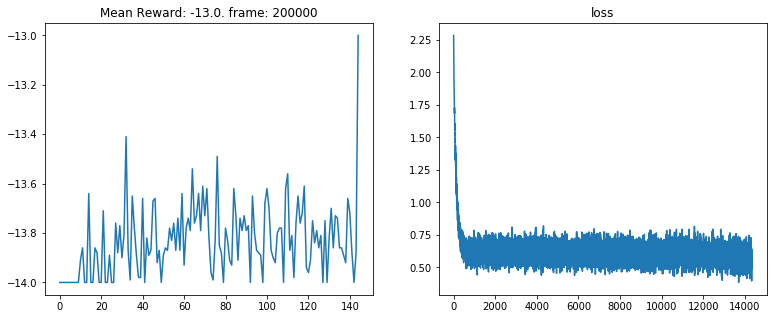

In [112]:
EXP_reward = []
for rep in range(1):
    

    num_bits = 11
    env = Env(num_bits)

    model        = Model(2 * num_bits, num_bits).to(device)
    target_model = Model(2 * num_bits, num_bits).to(device)
    update_target(model, target_model)

    model_imitation = model

    #hyperparams:
    batch_size = 5
    new_goals  = 5
    max_frames = 200000

    optimizer = optim.Adam(model.parameters())
    optimizer_imitation = optim.Adam(model_imitation.parameters())
    replay_buffer = ReplayBuffer(10000)
    replay_buffer_imitation = ReplayBuffer_imitation(50000)

    frame_idx = 0
    all_rewards = []
    losses = []
    plotter = []

    while frame_idx < max_frames:
        state, goal = env.reset()
        done = False
        episode = []
        total_reward = 0
        while not done:
            action = get_action(model, state, goal)
            next_state, reward, done, _ = env.step(action)
            
            action_imit = get_action_imitation(model,state,goal)
            
            #if action_imit == action:
            #    flag = 1
            #    reward+=0.6
            #    '''超参'''
            #else:
            #    flag = 0
            
            episode.append((state, reward, done, next_state, goal))
            replay_buffer.push(state, action, reward, next_state, done, goal)
            state = next_state
            total_reward += reward #- flag * 0.6
            frame_idx += 1

            if frame_idx % 10000 == 0:
                plot(frame_idx, [np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)], losses)
                #print(plotter)
                plotter=[np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)]
        all_rewards.append(total_reward)


        new_episode = []
        for i,(state, reward, done, next_state, goal) in enumerate(episode):
            for t in np.random.choice(num_bits, new_goals):
            #for t in [i]:
                try:
                    episode[t]
                except:
                    continue
                #if i<t:
                #    continue
                new_goal = episode[t][-2]
                if np.sum(next_state == new_goal) == num_bits:
                    reward = 0
                else:
                    reward = -1
                    
                '''加了一个action'''
                action = get_action(model, state, goal)
                replay_buffer.push(state, action, reward, next_state, done, new_goal) # HER
                if t == i:
                    replay_buffer_imitation.push(state, action, reward, next_state, done, new_goal) # IER
                #new_episode.append((state, reward, done, next_state, new_goal))


        loss1 = compute_cross_ent_error(500)
        loss = compute_td_error(batch_size)
        if loss1 is not None: losses.append(loss1.data.item())
            
    EXP_reward.append(plotter)